### Imports

In [36]:
import cv2
import time
import perfo

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_limbus
from helpers.misc import \
    jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed, geometric_median
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


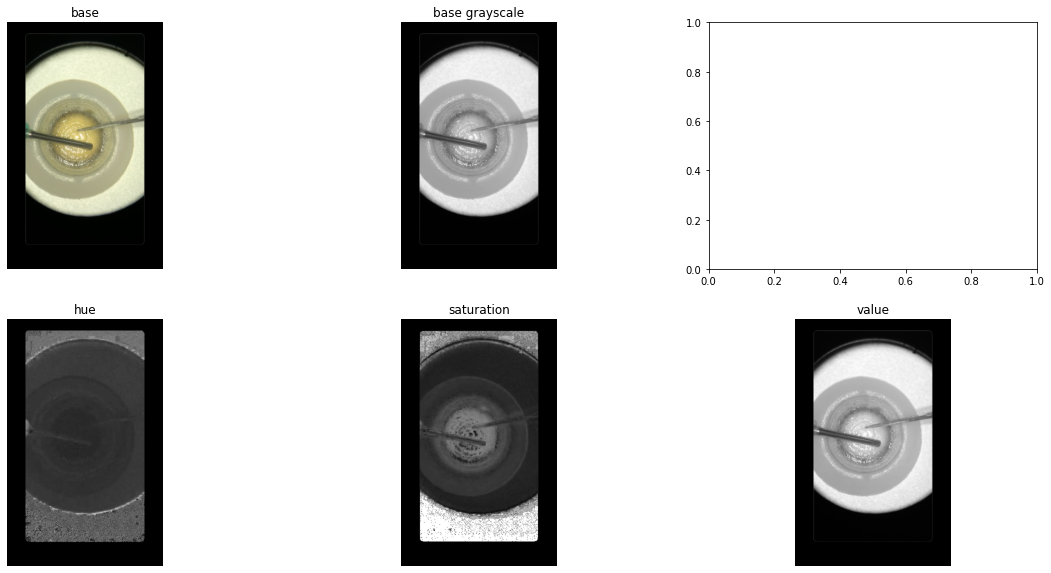

size: 312x496


In [179]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base4.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### Plain detection without any additional treatment

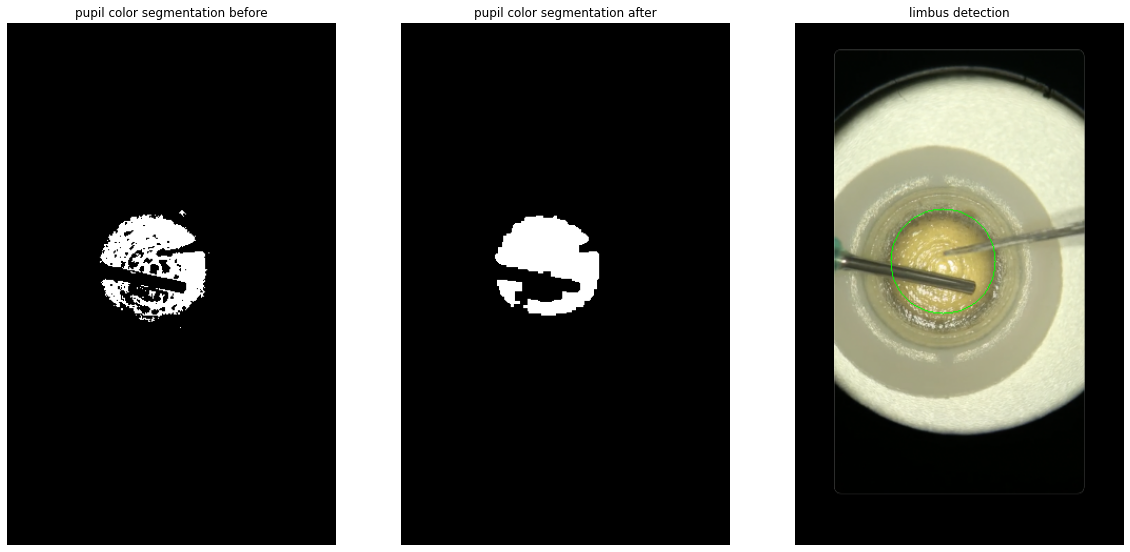

In [180]:
# color thresholding
pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

# morphological processing
kernel = np.ones((3,3),np.uint8) # could be automatically set based on moments

base_pupil_thres_copy = base_pupil_thres.copy()
base_pupil_thres_copy = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_OPEN, kernel)
base_pupil_thres_copy = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_CLOSE, kernel, iterations=3)

# image moments calculation
moments = cv2.moments(base_pupil_thres_copy, binaryImage=True)
center = (round(moments['m10']/moments['m00']),
                  round(moments['m01']/moments['m00']))
std_est = np.sqrt(moments['mu20']/moments['m00']) + \
          np.sqrt(moments['mu02']/moments['m00'])
std_est /= 2
radius = round(2*std_est)

base_copy = base_rgb.copy()
cv2.circle(base_copy, center, radius, (0,255,0))

# visualization
fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('pupil color segmentation before')
plots[0].imshow(base_pupil_thres, cmap='gray')
plots[0].axis('off')

plots[1].set_title('pupil color segmentation after')
plots[1].imshow(base_pupil_thres_copy, cmap='gray')
plots[1].axis('off')

plots[2].set_title('limbus detection')
plots[2].imshow(base_copy)
plots[2].axis('off')

plt.show()

### PCA-based correction

In [181]:
start = time.time()

points = np.array((
    np.where(base_pupil_thres_copy == 255)[1],
    np.where(base_pupil_thres_copy == 255)[0])).T
points = points.astype(np.float32)
mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv2.PCACompute2(points, mean)
mean = mean[0]

end = time.time()

print('runtime: %f ms' % (1000*(end - start)))
print('centroid: %s' % str(mean))
print()
print('primary eigenvector: %s' % str(eigenvectors[0]))
print('secondary eigenvector: %s' % str(eigenvectors[1]))
print('eigenvalues: %s' % str(eigenvalues.T[0]))

runtime: 2.099991 ms
centroid: [140.09184 226.37073]

primary eigenvector: [0.7983144 0.6022409]
secondary eigenvector: [-0.6022409  0.7983144]
eigenvalues: [705.2425  536.56445]


correction

In [182]:
# mean shift computation
mean_shift_scale = 2*(np.sqrt(eigenvalues[0][0]) - np.sqrt(eigenvalues[1][0]))
mean_shift = mean_shift_scale*eigenvectors[1]

# determining correct sign
image_center = np.array(base_rgb.shape[:2], dtype=np.float32)/2
mean_corrected1 = mean - mean_shift
mean_corrected2 = mean + mean_shift

mean_corrected = None
if np.linalg.norm(mean_corrected1 - image_center) > np.linalg.norm(mean_corrected2 - image_center):
    mean_corrected = mean_corrected1
else:
    mean_corrected = mean_corrected2

print('mean shift correction: %f' % mean_shift_scale)
print('corrected centroid: %s' % str(mean_corrected))

mean shift correction: 6.785084
corrected centroid: [136.00558 231.78735]


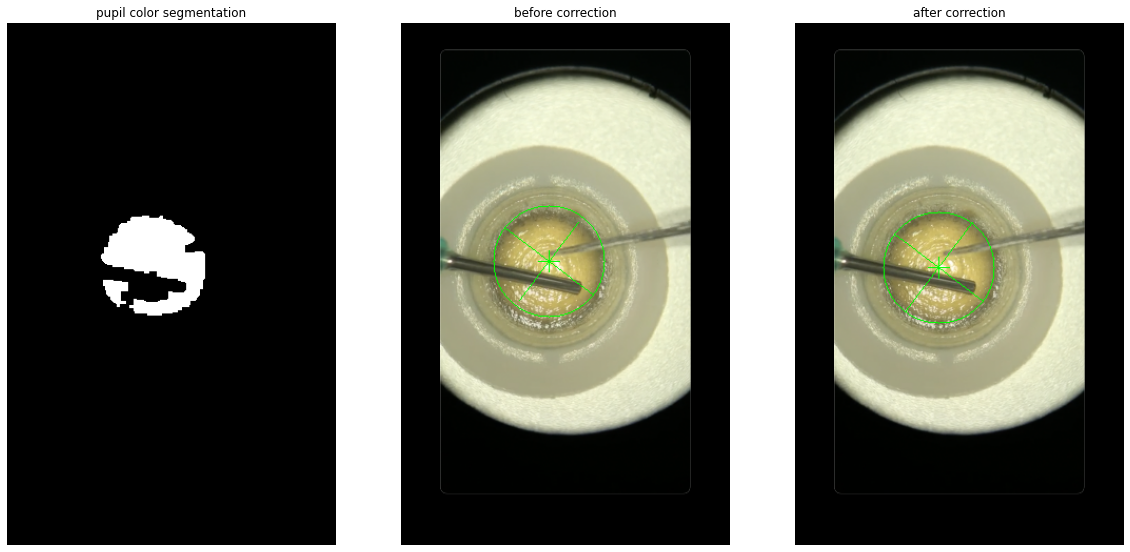

In [183]:
# before correction
base_copy_before = base_rgb.copy()
cv2.drawMarker(base_copy_before, tuple(mean.round().astype(np.int32)), (0,255,0))

scale = 2*np.sqrt(eigenvalues[0][0])
line_start = tuple((mean - scale*eigenvectors[0]).round().astype(np.int32))
line_end = tuple((mean + scale*eigenvectors[0]).round().astype(np.int32))
cv2.line(base_copy_before, line_start, line_end, (0,255,0))
cv2.circle(base_copy_before, tuple(mean.round().astype(np.int32)), round(scale), (0,255,0))

scale = 2*np.sqrt(eigenvalues[1][0])
line_start = tuple((mean - scale*eigenvectors[1]).round().astype(np.int32))
line_end = tuple((mean + scale*eigenvectors[1]).round().astype(np.int32))
cv2.line(base_copy_before, line_start, line_end, (0,255,0))

# after correction
base_copy_after = base_rgb.copy()
cv2.drawMarker(base_copy_after, tuple(mean_corrected.round().astype(np.int32)), (0,255,0))

scale = 2*np.sqrt(eigenvalues[0][0])
line_start = tuple((mean_corrected - scale*eigenvectors[0]).round().astype(np.int32))
line_end = tuple((mean_corrected + scale*eigenvectors[0]).round().astype(np.int32))
cv2.line(base_copy_after, line_start, line_end, (0,255,0))
cv2.circle(base_copy_after, tuple(mean_corrected.round().astype(np.int32)), round(scale), (0,255,0))

line_start = tuple((mean_corrected - scale*eigenvectors[1]).round().astype(np.int32))
line_end = tuple((mean_corrected + scale*eigenvectors[1]).round().astype(np.int32))
cv2.line(base_copy_after, line_start, line_end, (0,255,0))

# visualization
fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('pupil color segmentation')
plots[0].imshow(base_pupil_thres_copy, cmap='gray')
plots[0].axis('off')

plots[1].set_title('before correction')
plots[1].imshow(base_copy_before)
plots[1].axis('off')

plots[2].set_title('after correction')
plots[2].imshow(base_copy_after, cmap='gray')
plots[2].axis('off')

plt.show()

In [55]:
(int(mean[0,0]), int(mean[0,1]))

(30, 160)

In [56]:
radius

47

In [57]:
np.sqrt(eigenvalues)

array([[28.368176],
       [18.728718]], dtype=float32)

In [29]:
base_pupil_thres_copy.shape

(417, 233)

In [10]:
base_pupil_thres_copy

data_pts = np.empty((sz, 2), dtype=np.float64)
for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
# Perform PCA analysis
mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)

NameError: name 'opening_closing' is not defined

Video demo

In [6]:
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

cap = cv2.VideoCapture('data/artificial/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    # performance measurement
    timer = cv2.getTickCount()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    pupil_thres = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )
    
    # morphological preprocessing
    pupil_thres = cv2.morphologyEx(pupil_thres, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    pupil_thres = cv2.morphologyEx(pupil_thres, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))
    
    # finding the center of the detected structure
    moments = cv2.moments(pupil_thres, binaryImage=True)
    
    # performance measurement
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if moments['m00'] != 0:
        center = (round(moments['m10']/moments['m00']),
                  round(moments['m01']/moments['m00']))
        std_est = np.sqrt(moments['mu20']/moments['m00']) + \
                  np.sqrt(moments['mu02']/moments['m00'])
        std_est /= 2
        radius = round(2*std_est)
        
        cv2.circle(frame, center, radius, (255,0,0))
        cv2.circle(frame, center, round(0.5*radius), (0,255,0))
        
        cv2.putText(frame, 'fps %d' % round(fps),
                    (5,25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,255,0), 1)
    else:
        cv2.putText(frame, 'moments could not be computed',
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,255,0),2)

    cv2.imshow('original', frame)
    cv2.imshow('thresholded', pupil_thres)
    cv2.imshow('blend', blended)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)